<a href="https://colab.research.google.com/github/kiddhcx/ECE720/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 720 Assignment Hands-on Project 2

In this assignment, we will explore how to test a DL model.

Before working on the assignment, it is highly recommended to read two papers: [DeepGauge: Multi-Granularity Testing Criteria for Deep Learning Systems](https://arxiv.org/pdf/1803.07519.pdf) and [DeepHunter: A Coverage-Guided Fuzz Testing Framework for Deep Neural Networks](https://dl.acm.org/doi/pdf/10.1145/3293882.3330579?casa_token=mGUOGHi9qrcAAAAA:G28BWlY6XueMERjYHKWyW7w5jfGQrzF3fyml6ThPX0Rq8yUE4NYTz28s83fllXvaRItcpflNbBtdEYs). Our materials will be highly relevant to these two papers.


In [3]:
! wget https://github.com/momentum-openspace/momentum-openspace.github.io/raw/new-template/files/asg2/asg2.zip
! unzip asg2.zip

--2022-03-03 00:53:54--  https://github.com/momentum-openspace/momentum-openspace.github.io/raw/new-template/files/asg2/asg2.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/momentum-openspace/momentum-openspace.github.io/new-template/files/asg2/asg2.zip [following]
--2022-03-03 00:53:54--  https://raw.githubusercontent.com/momentum-openspace/momentum-openspace.github.io/new-template/files/asg2/asg2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 770861 (753K) [application/zip]
Saving to: ‘asg2.zip.1’

asg2.zip.1          100%[===================>] 752.79K  --.-KB/s    in 0.05s   

2022-0

In [4]:
import imp
import platform

py_version = platform.python_version().split('.')[1]
if py_version == '7':
    all_utils = imp.load_compiled("all_utils", "./all_utils.cpython-37.pyc")
elif py_version == '8':
    all_utils = imp.load_compiled("all_utils", "./all_utils.cpython-38.pyc")
elif py_version == '9':
    all_utils = imp.load_compiled("all_utils", "./all_utils.cpython-39.pyc")
else:
    raise NotImplementedError('Only supports Python>=3.7')

### Content:

1. The difference between traditional software and AI model <font color='red'> (4 points)</font>

    - Please summarize the characteristics of traditional software and compare it to AI model (2 points)
    - Please summarize the characteristics of AI model and compare it to traditional software (2 points)
    
    
2. Quality assurance of DL models <font color='red'> (13 points)</font>

    2.1 Testing metric <font color='red'> (7 points)</font>
    
    - Profile the DNN on training data (3 points)
    - Implement Neuron Boundary Coverage (4 points)
    
    2.2 Mutation <font color='red'> (6 points)</font>

    - Answer the question (2 points)
    - Complete Algorithm2 (4 points)

3. Experiments <font color='red'> (3 points)</font>
    
    - Conduct experiments on mutation testing.


## 1. The difference between traditional software and AI model <font color='red' size=5> (4 points)</font>

![Intro.png](https://raw.githubusercontent.com/momentum-openspace/momentum-openspace.github.io/new-template/files/asg2/pic/Intro.png)

<center> Difference between traditional software and AI models (From DeepHunter)</center>

In [5]:
# Load necessary package for the experiments
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

def plot_image(image):
    fig = plt.figure()
    image = np.squeeze(image)
    plt.imshow(image, cmap='bone')

In [6]:
# Get ready for MNIST dataset
data_path = './data'
train_data = datasets.MNIST(root=data_path, train=True, download=True)

### 1.1 Traditional software

Now assume you are a developer who wants to develop a software for recognizing hand-written digit.

In [7]:
# Turn images into numpy array.
number_a = np.array(train_data[0][0])
number_b = np.array(train_data[600][0])

Text(0.5, 0, 'Image b')

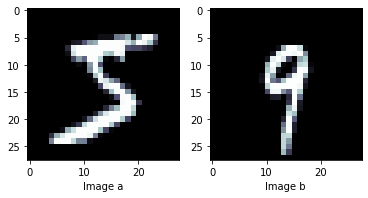

In [8]:
# Visualize two examples.
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(number_a, cmap='bone')
ax.set_xlabel("Image a")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(number_b, cmap='bone')
ax.set_xlabel("Image b")

In [9]:
# Compute the sum of pixel value of each images.
print("The sum of pixel value of image A is: {}".format(np.sum(number_a.reshape(-1))))
print("The sum of pixel value of image B is: {}".format(np.sum(number_b.reshape(-1))))

The sum of pixel value of image A is: 27525
The sum of pixel value of image B is: 15734


You may go through the examples above and find that number "5" has larger sum of pixel value than that of number "9", based on this observation, a naive judegement could be made: For those images with sum of pixel value is above `20000`, it is the digit `5`, otherwise it is the digit `9`

In [10]:
def recognize_digit(image):
    # --- Below is the logic of this function ---
    if np.sum(image.reshape(-1)) > 20000:
        return 5
    else:
        return 9
    # --- Above is the logic of this function ---

print("Image a is {}".format(recognize_digit(number_a)) )
print("Image b is {}".format(recognize_digit(number_b)) )

Image a is 5
Image b is 9


<font color='blue' size=4> Please summarize the characteristics of traditional software and compare it to AI model</font> <font color='red' size=4> (2 points)</font>

![traditional.png](https://raw.githubusercontent.com/momentum-openspace/momentum-openspace.github.io/new-template/files/asg2/pic/traditional.png)

### 1.2 AI model

Now let's see the AI model. We have a pre-trained AI model ready for you and let's load it.

In [11]:
from all_utils import Lenet5
from all_utils import load_model

model = load_model(Lenet5, "./lenet.pt")

<center> The AI model architecture </center>

<img src="https://raw.githubusercontent.com/momentum-openspace/momentum-openspace.github.io/new-template/files/asg2/pic/lenet_vis.png" height=1000 weight=600> 

The above figure shows the computation graph of the AI model. In each element, there are some computations going on. All the blue components with ".weight" can also be taken as "neurons." 

Let's predict the image using AI model.

In [12]:
def recognize_digit_AI(image, model):
    tensor = all_utils.image_to_tensor(image)
    # --- Below is the prediction made by the model ---
    with torch.no_grad():
        result = model(tensor)
    # --- Above is the prediction made by the model ---
    return np.argmax(result.cpu(), axis = 1)[0]

print("Image a is {}".format(recognize_digit_AI(number_a, model)) )
print("Image b is {}".format(recognize_digit_AI(number_b, model)) )

Image a is 5
Image b is 9


<font color='blue' size=4> Please summarize the characteristics of AI model and compare it to traditional software </font> <font color='red' size=4> (2 points)</font>

Hint: Neurons in the AI model can interact with each other. They are connected with complex non-linear activation functions.

![Title](https://raw.githubusercontent.com/momentum-openspace/momentum-openspace.github.io/new-template/files/asg2/pic/AI.png)

## 2. Quality assurance of DL models <font color='red' size=5> (13 points)</font>

So far, we have explored the differences between deep learning models and traditional software. Now let's think about one of the main topics in this course: how to improve the quality of machine learning systems. 

To do this, let's first review the developing process of classical software:

`Software development --> Software testing --> Software debugging --> Software development.`

And machine learning systems have similar process:

`Model training --> Model evaluation --> Model debugging/ Architecture improvement --> Model (re)training.`

Normally Model evaluation is done by testing on test set. Similar to the software testing procedure, this is a very important step towards quality assurance of DL models. However, there are multiple questions remaining:

1. The size of the test set is usually limited, because it could be expensive to collect data with labeled data. Hence it's hard to cover all the corner cases in the test set. 

    a. To solve this problem, we need to develop a method to generate more test cases. 
    b. Like test generation in traditional automated software testing, we need to generate "valid" test cases. For example, you can not generate a cat image to test the handwritten digit recognition system.
    

2. Let's suppose that you now have a large enough test set. The next question is, how can we tell whether the ML system has been comprehensively tested or not. Or, in other words, what is the criteria to stop the testing and how to measure whether the ML system has been well-tested?

    a. The "code coverage" metric is usually used in traditional software, and we also have practiced it in the last assignment. If we know that every logical branch in the software has been covered in the testing, we can be more confident to say that this software has been comprehensive tested.  
    
    
3. Now if you have a testing metric like "code coverage" and a test case generation method for testing machine learning systems, the next step is to generate as diverse test cases as you can to improve the testing coverage. Is it possible to "guide" the test case generation process instead of do it randomly?

We will cover all these three questions in the following

### Goal: Test AI models efficiently

### TODO:

### 1. Define a testing metric that is suitable for testing DL models.
    
### 2. Find possible test cases generation methods.
    
### 3. Design metric-guidance testing technique.

### 2.1 Testing metric <font color='red' size=3> (7 points)</font>

#### 2.1.1 Definition of "neuron"

In a DNN with only linear layer enabled ([MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron)), the term "neuron" represents a computing unit. Each neuron is fully-connected with all neurons on the next layer, and each connection has a weight. 

`output = linear_layer(input)`.
    
However, in another kind of neural network called Convolutional Neural Networks (CNNs), which is known more prevalent in the image classification task, there is a special computation unit called "convolution". We refer the reader to a nice resource from Stanford University: [Convolutional Neural Networks (CNNs / ConvNets)](https://cs231n.github.io/convolutional-networks/) if you are not familiar with CNNs. Generally speaking, it is more ambiguous to describe a "neuron" in CNNs. We will follow the insights in the aforementioned material:

> Every entry in the 3D output volume can also be interpreted as an output of a neuron that looks at only a small region in the input and shares parameters with all neurons to the left and right spatially (since these numbers all result from applying the same filter).
    


In [13]:
# Before the experiment, let's first load the data
train_loader = all_utils.get_training_loader("./train_idx.pt")
test_loader = all_utils.get_test_loader()

Notice: 

Here the train_loader and test_loader are `torch.utils.data.DataLoader` (reference: [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)). It works like an iterator that automatically returns you the image in each `batch`. The batch size is set to 64 here. In other words, for the tensor returned by the loader, the returned tensor shape is (64, 1, 28, 28), where 64 is the batch_size, 1 is the number of channel, the remaining two dimensions are the height and width of the image. 

(64, 1, 28, 28) --> (N, C, H, W)

While doing image processing, the image is usually in the format (H, W, C), where channel is in the last dimension.

You may wonder why pytorch chooses (N, C, H, W). This is because in this format the memory access pattern is beneficial for convolution implementations. If you are interested for this, you can check this [presentation](https://developer.download.nvidia.com/video/gputechconf/gtc/2019/presentation/s9926-tensor-core-performance-the-ultimate-guide.pdf)

#### 2.1.2 Introduction to DNN testing metric: Neuron Boundary Coverage

In this section we will explore the testing metric at Neuron-level. You can check for the paper [DeepGauge](https://dl.acm.org/doi/pdf/10.1145/3238147.3238202?casa_token=xNahdy3nsNUAAAAA:FVq-aGLpMPYO9s2MgstFsej05GTcGLCnaOZzse1k61C92jqyli4iCYLFHYopNk8PIPzqbVSwDqssC4I) for more information.

Intuitively, we have "code coverage" for classical software. If we takes the neurons as the basic components in a DNN, we can also define neuron-based coverage metric to measure how good the testing is and guide the testing. This is the basic logic behind Neuron-Level Coverage Criteria in [DeepGauge](https://dl.acm.org/doi/pdf/10.1145/3238147.3238202?casa_token=xNahdy3nsNUAAAAA:FVq-aGLpMPYO9s2MgstFsej05GTcGLCnaOZzse1k61C92jqyli4iCYLFHYopNk8PIPzqbVSwDqssC4I). 

The functionality (i.e., neuron output) for each neuron of a DNN should follow some statistical distribution, and this distribution is implicitly determined by the training data. The output distribution analysis would allow to approximately characterize how wide the range of each neuron's output on the training data.

So, we can first analyze the output distribution of a neuron in the training data, find its distribution, and then analyze the output distribution of a neuron in the test data. If the later one "covers" the former, we can conclude that the testing data has covered some cases which the model never saw in the training process.

Now let's take a look at the Neuron Boundary Coverage (NBC).

<font color='red' size=3> Definition 1</font> 

For a neuron n, let $high_n$ and $low_n$ be its upper and lower boundary output values, respectively, on the value range of its activation function, where $high_n$ and $low_n$ are derived from the training dataset analysis.

<font color='red' size=3> Definition 2</font> 

For a test input $x \in T$ , we say that a DNN is located in its major function region given x iff $\forall n \in N : \phi(x,n) \in [low_n, high_n]$ .

As you can see, here we define the "distribution" of a neuron by measuring its **output range**. Based on this, we then define:

<font color='red' size=3> Definition 3</font> 

UpperCornerNeuron = {$n \in N | \exists x \in T: \phi(x, n) \in (high_n, +\infty)$};

LowerCornerNeuron = {$n \in N | \exists x \in T: \phi(x, n) \in (-\infty, low_n)$};

Definition 3 define two types of situations where the output of neuron is in the corner-case regions (Not present in the training data.) We assume that if at test time, the more corner cases you find, the better chance you can test the DNN thoroughly.

Finally, we give the definition of Neuron Boundary Coverage:

<font color='red' size=3> Definition 4</font>

NBCov(T) = $\frac{|UpperCornerNeuron| + |LowerCornerNeuron|}{2 \times |N|}$

Where $|\cdot|$ indicates the number, e.g., $|N|$ indicates the number of all neurons.

**In the following, we will implement NBC.**

<font color='blue' size=4> Profile the DNN on training data</font>

We will first profile the DNN on training data to get the output range.

(What we are doing here is just like instrumentation in traditional software testing.)

To get the output of each neuron, we need to get the output of each intermediate layer. For PyTorch, this can be done using hook. If you are interested in thie technique, you can check this video: [PyTorch Hooks Explained - In-depth Tutorial](https://www.youtube.com/watch?v=syLFCVYua6Q). While in this assignment we have implemented a function called `feature_list` that returns all the intermediate result for you:

```
logits, out_list, name_list = model.feature_list(data)
# logits: the final output
# output_list: the output of each intermediate layer
# name_list: the list of names for each intermediate layer
```

Use this function, let's profile the DNN

<font color='blue' size=3> Please complete the todo listed in the function shown below</font> <font color='red' size=3> (3 points)</font>

Functions that you \*may\* need to use here:

[function Tensor.reshape](https://pytorch.org/docs/stable/generated/torch.reshape.html)

    Returns a tensor with the same data and number of elements as input, but with the specified shape. 
    `torch.tensor([1, 2]).reshape`

[function Tensor.max](https://pytorch.org/docs/stable/generated/torch.max.html?highlight=max#torch.max)
    
    Returns the maximum value of all elements in the input tensor.
    `torch.tensor([1, 2]).max`

[function Tensor.min](https://pytorch.org/docs/stable/generated/torch.min.html?highlight=min#torch.min)
    
    Returns the minimum value of all elements in the input tensor.
    `torch.tensor([1, 2]).min`

[torch.flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html?highlight=flatten#torch.flatten)
    
    Flattens input by reshaping it into a one-dimensional tensor. 

In [23]:
import collections
def profile_DNN(net, dataloader):
    """
    Profile the DNN and return a cov_dict contains the necessary information
    ---
    Args
        net: torch.nn.Module Deep learning model.
        dataloader: torch.utils.data.DataLoader The pytorch dataloader.
    Returns:
        cov_dict: a dict contains (layer_name, neuron_id) --> (neurons_min, neurons_max) mapping.
    
    """
    net.eval()
    cov_dict = collections.OrderedDict()
    batch_num = len(dataloader)
    for idx, (data, label) in enumerate(dataloader):
        with torch.no_grad():
            logits, out_list, name_list = net.feature_list(data)
        if idx % 100 == 0:
            print("* finish {}/{} proportion".format(idx, batch_num))
        
        # Iterate through all output layers in the output list
        for layer_id in range(len(out_list)):
            cur_layer = name_list[layer_id] # record the name of current layer
            
            '''
            Recall the definition of neurons. For a linear layer, the output is [Batch_size, neurons]
            While for a convolutional layer, the output is [Batch_size, channel, H, w]
            As we define that every entry in the 3D output volume is one neuron, 
            the number of neurons in conv layer is just channel * H * W.
            '''
            
            cur_neuron_num = 1
            
            '''
            Please compute the number of neurons in the DNN and store the result in cur_neuron_num.
            '''
            
            # ======Below is TODO====== #
            if len(out_list[layer_id].shape) == 4:
              cur_neuron_num = out_list[layer_id].shape[1] * out_list[layer_id].shape[2] * out_list[layer_id].shape[3]
            else:
              cur_neuron_num = out_list[layer_id].shape[1]
            # ======Above is TODO====== #
            
            '''
            Please records the max value and min value over **batch** (the first dimension) from the **out_list**
            Hint: you can use torch.flatten or reshape to turn a multi-dimension tensor
            into one-dimension tensor to [C, H, W] --> [N] can be easily used to represent neurons.
            Data structure used here: out_list, neurons_max, neurons_min
            '''
            
            # ======Below is TODO====== #
            out_list[layer_id] = torch.flatten(out_list[layer_id],start_dim=1)
            neurons_max = torch.max(out_list[layer_id],0)
            neurons_min = torch.min(out_list[layer_id],0)
            
            # ======Above is TODO====== #
            for neuron_id in range(cur_neuron_num):
                # Please record the range of the neuron for key (cur_layer, neuron_id).
                if (cur_layer, neuron_id) not in cov_dict:
                    # The fisrt time to record the pair.
                    cov_dict[(cur_layer, neuron_id)] = [None, None] # Initialize [Lower, upper]
                
                profile_data_list = cov_dict[(cur_layer, neuron_id)]

                '''
                Please compare the result in neurons_max, neurons_min with that in profile_data_list
                If neurons_max is larger than the data in profile_data_list
                store it in the upper_bound and store back to the profile_data_list.
                Data structure used here: lower_bound, upper_bound, neurons_min, neurons_max
                '''
                
                # ======Below is TODO====== #
                if profile_data_list == [None,None]:
                  upper_bound = neurons_max.values[neuron_id]
                  lower_bound = neurons_min.values[neuron_id]
                else:
                  if neurons_max.values[neuron_id] > profile_data_list[1]:
                    upper_bound = neurons_max.values[neuron_id]
                  else:
                    upper_bound = profile_data_list[1]
                  if neurons_min.values[neuron_id] < profile_data_list[0]:
                    lower_bound = neurons_min.values[neuron_id]
                  else:
                    lower_bound = profile_data_list[0]
                # ======Above is TODO====== #

                profile_data_list[0] = lower_bound
                profile_data_list[1] = upper_bound
                cov_dict[(cur_layer, neuron_id)] = profile_data_list  
    return cov_dict

In [15]:
from all_utils import check_cov_list

In [24]:
train_cov_dict = profile_DNN(model, train_loader)
print(train_cov_dict)
check_cov_list(train_cov_dict)

* finish 0/750 proportion
* finish 100/750 proportion
* finish 200/750 proportion
* finish 300/750 proportion
* finish 400/750 proportion
* finish 500/750 proportion
* finish 600/750 proportion
* finish 700/750 proportion
OrderedDict([(('conv1', 0), [tensor(0.0404), tensor(0.1967)]), (('conv1', 1), [tensor(-0.0557), tensor(0.2304)]), (('conv1', 2), [tensor(-0.2074), tensor(0.4038)]), (('conv1', 3), [tensor(-0.4023), tensor(0.5574)]), (('conv1', 4), [tensor(-0.6094), tensor(0.6706)]), (('conv1', 5), [tensor(-0.5494), tensor(0.7383)]), (('conv1', 6), [tensor(-0.6215), tensor(0.6311)]), (('conv1', 7), [tensor(-0.5804), tensor(0.7734)]), (('conv1', 8), [tensor(-0.6085), tensor(1.2341)]), (('conv1', 9), [tensor(-0.5973), tensor(1.5266)]), (('conv1', 10), [tensor(-0.6256), tensor(1.2675)]), (('conv1', 11), [tensor(-0.6134), tensor(1.2763)]), (('conv1', 12), [tensor(-0.6327), tensor(1.3557)]), (('conv1', 13), [tensor(-0.6134), tensor(1.1935)]), (('conv1', 14), [tensor(-0.6092), tensor(1.2438)

'Congratulation! You have passed the sanity check'

Well Done! Let's now implement the NBC metric

<font color='blue' size=4> Implement NBC</font>

<font color='blue' size=3> Please complete the todo listed in the function shown below</font> <font color='red' size=3> (4 points)</font>

In [21]:
def compute_NBCov(net, dataloader, cov_dict):
    """
    Compute the Neuron Boundary Coverage metric on a given data loader.
    ---
    Args
        net: torch.nn.Module Deep learning model.
        dataloader: torch.utils.data.DataLoader The pytorch dataloader.
        cov_dict: a dict contains (layer_name, neuron_id) --> (neurons_min, neurons_max) mapping.
    Returns:
        result: the coverage result
    
    """
    net.eval()
    coverage_recorder = collections.OrderedDict()
    batch_num = len(dataloader)
    for idx, (data, label) in enumerate(dataloader):
        with torch.no_grad():
            logits, out_list, name_list = net.feature_list(data)
        if idx % 100 == 0:
            print("* finish {}/{} proportion".format(idx, batch_num))
        
        # Iterate through all output layers in the output list
        for layer_id in range(len(out_list)):
            # record the name of current layer
            cur_layer = name_list[layer_id]
            cur_neuron_num = 1
            
            '''
            Please compute the number of neurons in the DNN and store the result in cur_neuron_num.
            Compute neurons_max and neurons_min based on **out_list**
            '''

            # ======Below is TODO====== #
            if len(out_list[layer_id].shape) == 4:
              cur_neuron_num = out_list[layer_id].shape[1] * out_list[layer_id].shape[2] * out_list[layer_id].shape[3]
            else:
              cur_neuron_num = out_list[layer_id].shape[1]   

            out_list[layer_id] = torch.flatten(out_list[layer_id],start_dim=1)
            neurons_max = torch.max(out_list[layer_id],0)
            neurons_min = torch.min(out_list[layer_id],0)
            # ======Above is TODO====== #

            # Compare the result in cov_dict and record neurons who has been covered.
            for neuron_id in range(cur_neuron_num):
                if (cur_layer, neuron_id) not in coverage_recorder:
                    # Init the coverage_recorder
                    # [(cur_layer, neuron_id)] = [0, 0] (LowerCornerNeuron, UpperCornerNeuron)
                    coverage_recorder[(cur_layer, neuron_id)] = [0, 0] # LowerCornerNeuron, UpperCornerNeuron
                
                '''
                Compare the output in neurons_min(neurons_max) and and cov_dict
                If the neuron is covered in LowerCorner, set LowerCornerNeuron = 1
                If the neuron is covered in UpperCorner, set UpperCornerNeuron = 1
                Data sturcture used here: cov_dict, neurons_min, neurons_max, coverage_recorder
                '''
                
                # ======Below is TODO====== #
                if neurons_min.values[neuron_id] <= cov_dict[(cur_layer, neuron_id)][0]:
                  coverage_recorder[(cur_layer, neuron_id)][0] = 1
                if neurons_max.values[neuron_id] >= cov_dict[(cur_layer, neuron_id)][1]:
                  coverage_recorder[(cur_layer, neuron_id)][1] = 1  
                # ======Above is TODO====== #
    
    num_of_coverage_neuron = 0
    
    '''
    Compute the number of neurons that are covered
    Data sturcture used here: coverage_recorder, result
    '''
    
    # ======Below is TODO====== #
    print(coverage_recorder)
    for value in coverage_recorder.values():
      if value == [0,0]:
        num_of_coverage_neuron += 1

    result = num_of_coverage_neuron
    # ======Above is TODO====== #
    
    return result

In [25]:
cov_result = compute_NBCov(model, test_loader, train_cov_dict)
print("Your cov result is {}".format(cov_result))

* finish 0/157 proportion
* finish 100/157 proportion
OrderedDict([(('conv1', 0), [0, 1]), (('conv1', 1), [0, 1]), (('conv1', 2), [0, 1]), (('conv1', 3), [0, 1]), (('conv1', 4), [0, 1]), (('conv1', 5), [0, 1]), (('conv1', 6), [0, 1]), (('conv1', 7), [1, 0]), (('conv1', 8), [0, 0]), (('conv1', 9), [1, 0]), (('conv1', 10), [0, 0]), (('conv1', 11), [1, 0]), (('conv1', 12), [0, 0]), (('conv1', 13), [1, 0]), (('conv1', 14), [1, 0]), (('conv1', 15), [0, 0]), (('conv1', 16), [0, 0]), (('conv1', 17), [0, 1]), (('conv1', 18), [0, 1]), (('conv1', 19), [0, 0]), (('conv1', 20), [0, 0]), (('conv1', 21), [0, 0]), (('conv1', 22), [0, 0]), (('conv1', 23), [1, 0]), (('conv1', 24), [0, 0]), (('conv1', 25), [0, 0]), (('conv1', 26), [0, 1]), (('conv1', 27), [0, 1]), (('conv1', 28), [0, 1]), (('conv1', 29), [0, 1]), (('conv1', 30), [1, 0]), (('conv1', 31), [0, 0]), (('conv1', 32), [0, 0]), (('conv1', 33), [0, 0]), (('conv1', 34), [1, 0]), (('conv1', 35), [0, 0]), (('conv1', 36), [0, 0]), (('conv1', 37), [0

### 2.2 Mutation <font color='red' size=3> (6 points)</font>

We have successfully implemented one testing metric. Now let's move to the next task: test generation.

As we've mentioned before, the size of test set is usually limited, but it's necessary to have more test cases if we want to know whether the trained DNN works well in a diverse environment. 

In traditional software testing, there is a technique called [mutation testing](https://en.wikipedia.org/wiki/Mutation_testing). Based on a limited number of initial testing programs (seeds), we can apply mutations (modifying a program in small ways) on them to get more testing cases.

In mutation testing, there are two things to keep in mind:

1. How to define the mutation operations, so the test cases after mutation is valid.

2. What's the expeceted behavior of the system under test for the mutated result?

#### 2.2.1 Mutation Testing: generate valid test cases <font color='red' size=3> (6 points)</font>

#### Mutation on images:

Since we are testing an image classifier, we need to search for transformations that are capable of transforming an image while keeping its semantics. There are many choices available, for example:
    
1. image_brightness: adjust the brightness of image.

2. image_noise: add some noise to the image.

3. image_scale: scale the image.

4. ...

In [ ]:
# Let's see some examples
# This is image_scale
from all_utils import image_scale
seed = np.expand_dims(number_a, 0)
result = image_scale(seed, 2)
plot_image(result)

In [ ]:
# Let's see some examples
# This is image_noise
from all_utils import image_noise
seed = np.expand_dims(number_a, 0)
result = image_noise(seed, 1)
plot_image(result)

These transformations are already been implemented, which could be classified as two types: 

class A (pixel value transformation).

class B (Affine transformation).

In [ ]:
from all_utils import Mutators
mutator_instance = Mutators()

In [ ]:
print("===Pixel value transformation===")
for i in mutator_instance.classA:
    print(mutator_instance.transformations[i].__name__)
print()
print("===Affine transformation===")
for i in mutator_instance.classB:
    print(mutator_instance.transformations[i].__name__)

We can easily define what is valid test cases for classical software. For example, a program that add `int a` with `int b` should not receive two imaginary numbers as input. But what is "valid" for DNN? Let's take a look at some definitions from DeepHunter.

<font color='red' size=3> Definition 5</font> 

Given an ideal human oracle O and a test x of a specific input domain, we define metamorphic mutation $M$ on $x$, if
$\forall x  \in M(x)$, we have $O(x') = O(x)$ .

This is to say, the metamorphic mutation does not change the semantic of the image. At least human should identify $x$ and $x'$ as the same image

<font color='red' size=3> Definition 6</font> 

An image $s'$ is one-time mutated from $s$ if $s'$ is generated after a transformation $t$ on $s$ (denoted as $s \stackrel{t}{\longrightarrow}$ $s'$). An image $s'$ is sequentially mutated from s if $s'$ is generated after a sequence of one-time mutations (denoted as $s \stackrel{t_0, t_1, \ldots, t_n}{\longrightarrow}$ $s'$).

Allow sequential mutataion can greatly improve the diversity of th testing

<font color='green' size=3> Summary: No matter for one-time mutations or a sequence of mutations, we have to ensure that they are metamorphic mutations</font> 

<font color='red' size=3> Definition 7</font>

The image $s'$ after transformation, and the original image $s$ are the same if:

1. There are no more than one affine transformation between $s'$ and $s$.

2. The pixel value changes between $s'$ and $s$ satisfied:

\begin{equation*}
    f(s, s') = \left\{\begin{array}{lr}
        L_{\infty}(s, s')  \leq 255 &\qquad \text{if} 
        \quad L_0(s, s') < \alpha \times size(s) \\
        L_{\infty}(s, s') < \beta \times 255 & \text{otherwise} \\
        \end{array}\right\} \\
\end{equation*}

(Equation 1 in [DeepHunter: A Coverage-Guided Fuzz Testing Framework for Deep Neural Networks](https://dl.acm.org/doi/pdf/10.1145/3293882.3330579?casa_token=mGUOGHi9qrcAAAAA:G28BWlY6XueMERjYHKWyW7w5jfGQrzF3fyml6ThPX0Rq8yUE4NYTz28s83fllXvaRItcpflNbBtdEYs))

Where:

\begin{equation*}
\begin{aligned}
    L_0(s, s') &= L_0(s_0, s_{j-1}) + L_0(s_j, s') \\
    L_{\infty}(s, s') &= L_0(s_0, s_{j-1}) + L_0(s_j, s') \\
\end{aligned}
\end{equation*}

$s_{j-1}$ is the transformed image before one affine transformation

$L_0$ and $L_{\infty}$ is the 0-norm and infinity-norm. $L_0(a, b) = sum((a - b) != 0)$, $L_0(a, b) = sum((a - b) != 0)$, $L_{\infty}(a, b) = max((a-b))$

The intuition behind Definition 7:

1. The pixel value should not be changed too much, so the semantic of the transformed image does not change. This change is measured by the subtraction.

2. Affine transformation will change the position of each pixel, making the norm measurement inaccurate (Take a look at `image_scale` example). As a result, we cut the sequence of transformations into two parts, measuring each independently.

Based on all the definitions above, we have Algorithm 2 in [DeepHunter: A Coverage-Guided Fuzz Testing Framework for Deep Neural Networks](https://dl.acm.org/doi/pdf/10.1145/3293882.3330579?casa_token=mGUOGHi9qrcAAAAA:G28BWlY6XueMERjYHKWyW7w5jfGQrzF3fyml6ThPX0Rq8yUE4NYTz28s83fllXvaRItcpflNbBtdEYs)

![Title](https://raw.githubusercontent.com/momentum-openspace/momentum-openspace.github.io/new-template/files/asg2/pic/alg_2.png)

<font color='blue' size=4> Please answer the following question</font> <font color='red' size=4> (2 points)</font>

<font color='blue' size=3> For all images returned in Algorithm 2, how many mutations are applied for each image if the success flag is True ? How does sequential mutations done in Deephunter? </font>

Hint: Take a look at algorithm 1

![Title](https://raw.githubusercontent.com/momentum-openspace/momentum-openspace.github.io/new-template/files/asg2/pic/alg_1.png)

<font color='blue' size=4> Please complete the todo listed in the function shown below</font> <font color='red' size=4> (4 points)</font>

<font color='blue' size=3> Please also attach three images after mutating in the final report</font> 

In [ ]:
import random
from all_utils import Mutators
import cv2
import time
import copy

# We are going to implement Line 5 ~ 18 in Algorithm 2 in the original paper.


def mutate_one(ref_img, 
               img, 
               has_Affine, 
               l0_ref, 
               linf_ref,
               alpha=0.02,
               beta=0.20, 
               try_num=50):
    """
    Mutate the image for once.
    Line 5 ~ 18 in Algorithm 2 in the original paper.
    Args
    ---
        ref_img: reference image. s0' in the original paper. In the format (C, H, W)
            Notice: s0 is the original reference image and we actually does not need it here.
        img: the seed. s in the original paper. In the format (C, H, W)
        has_Affine: Flag for indicating whether we have applied affine transformation on the image.
        l0_ref: The value for L_0(s_0, s_{j-1}). It is used to compute L_0(s_0, s_n) in the equation 2.
        linf_ref: The value for L_infinity(s_0, s_{j-1}). It is used to 
            compute L_infinity(s_0, s_n) in the equation 2.
        alpha: alpha in equation 1.
        betra: beta in equation 1.
        try_num: TRY_NUM in Algorithm 2.
        
    Returns:
        ref_img: reference image. s0' in the original paper.
        img: the image after transformation
        has_Affine: Updated flag
        changed: whether there is actually change for the image.
        l0_ref: updated l0_ref.
        linf_ref: updated line_ref.
    """
    # ref_img is the reference image, img is the seed

    # cl means the current state of transformation
    # 0 means it can select both of Affine and Pixel transformations
    # 1 means it only select pixel transformation because an Affine transformation has been used before

    # l0_ref, linf_ref: if the current seed is mutated from affine transformation, we will record the l0, l_inf
    # between initial image and the reference image. i.e., L0(s_0,s_{j-1}) L_inf(s_0,s_{j-1}) in Equation 2 of the paper

    # tyr_num is the maximum number of trials in Algorithm 2
    
    if isinstance(ref_img, torch.Tensor):
        ref_img = ref_img.numpy()
        img = img.numpy()
        is_torch = True
    else:
        is_torch = False
        
    c, h, w = img.shape
    mutator_instance = Mutators()
    # a, b is the alpha and beta in Equation 1 in the paper

    # l0_threshold: alpha * size(s), l_infinity_threshold: beta * 255 in Equation 1
    l0_threshold = int(alpha * c * h * w)
    l_infinity_threshold = int(beta * 255)
    ori_shape = ref_img.shape
    
    for ii in range(try_num):
        random.seed(time.time())
        if has_Affine == 0:  # 0: can choose class A and B Line-6 of the algorithm
            tid = random.sample(mutator_instance.classA + mutator_instance.classB, 1)[0]
            # Randomly select one transformation   Line-7 in Algorithm2
            transformation = mutator_instance.transformations[tid]
            params = mutator_instance.params[tid]
            # Randomly select one parameter Line 10 in Algo2
            param = random.sample(params, 1)[0]

            # Perform the transformation  Line 11 in Algo2
            img_new = transformation(copy.deepcopy(img), param)
            img_new = img_new.reshape(ori_shape)
            
            
            '''
            Notice: the Equation 1 and Line 12 in Algo2 is satisfied 
            if the transformation is affine transformation
            So the line 12 of the algorithm is moved down.
            '''
            
            if tid in mutator_instance.classA: # Line
                
                '''
                check whether it is a valid mutation. i.e., Equation 1 and Line 12 in Algo2
                You need to compute l0_ref, linf_ref, and compare them with their own
                threshold.
                Data structure used here:  ref_img, img_new, l0_ref, l0_threshold
                  linf_ref, l_infinity_threshold
                '''
                
                # ======Below is TODO====== #
                if : # line 12 of the algorithm 2. We move the comparision down here.
            

                    return # Please fill the return field.
                # ======Above is TODO====== #
                
            else:  # B, C
                
                '''
                If the current transformation is an Affine trans, we will update the reference image and
                the transformation state of the seed.
                '''
                
                ref_img = transformation(copy.deepcopy(ref_img), param)
                ref_img = ref_img.reshape(ori_shape)
                    
                # ======Below is TODO====== #
                return # Please fill the return field.
                # ======Above is TODO====== #
            
        elif has_Affine == 1: # 0: can only choose class A. Line 6 of the original algorithm fails.
            tid = random.sample(mutator_instance.classA, 1)[0]
            transformation = mutator_instance.transformations[tid]
            params = mutator_instance.params[tid]
            param = random.sample(params, 1)[0]
            img_new = transformation(copy.deepcopy(img), param)
            
            
            '''
            Compute the value in Equation 2 in the paper.
            So the comparision can be done below.
            Data structure used here: ref_img, img_new, l0_ref, linf_ref
            '''
            
            # ======Below is TODO====== #

            if  : # line 12 of the algorithm 2. We move the comparision down here.
                # The if statement is satisified, we can return the result.
                return # Fill the return field.
            
            # ======Above is TODO====== #
            
    # Otherwise the mutation is failed. Line 20 in Algo 2
    return ref_img, img, has_Affine, False, l0_ref, linf_ref

In [ ]:
seed = np.expand_dims(number_a, 0)

In [ ]:
ref_img_list = list()
new_img_list = list()
affline_flag_list = list()
l0_ref_list = list()
linf_ref_list = list()

In [ ]:
result = mutate_one(
        seed,
        seed,
        False,
        0,
        0
)
result = all_utils.turn_numpy_into_torch_array(result)
# Below are the data structures that store the necessary info
# for future mutation.
ref_img_list.append(result[0])
new_img_list.append(result[1]) # T in the original paper
affline_flag_list.append(result[2])
l0_ref_list.append(result[3])
linf_ref_list.append(result[4])

In [ ]:
plot_image(result[1])

## 3. Experiments <font color='red' size=5> (3 points)</font>

In this section, you are asked to use `Algorithm 2` to do the mutation testing and use function `compute_NBCov` to evaluate the results.

There are multiple ways to do the mutation testing:

1. Just mutate every image for once in the test set. And combine the test set and mutated images as new dataset for testing.

2. Implement Algorithm 1 in the original paper to guide the testing.

3. Random select part of the images for testing.

4. ...

This is an open-ended question, feel free to use any ideas that come to your mind

Here is an example to build self-defined dataset.

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
test_image_set = list()
labels = list()

for imgs, label in test_loader:
    for i in range(len(imgs)):
        test_image_set.append(imgs[i].unsqueeze(0))
        labels.append(int(label[i]))
        
        # ======Below is TODO====== #
        # Please remember to use `result = all_utils.turn_numpy_into_torch_array(result)`
            
        # ======Above is TODO====== #

In [ ]:
new_test_dataset = TensorDataset(torch.cat(test_image_set), torch.tensor(labels))
new_test_dataloader = torch.utils.data.DataLoader(new_test_dataset, batch_size=64)

In [ ]:
# train_cov_dict is obtained at section 2.1.2
cov_result = compute_NBCov(model, new_test_dataloader, train_cov_dict)

In [ ]:
print(cov_result)